# Spectral matching

In [1]:
import re
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge

In [2]:
def read_raster(path, bands=None):
    """Read raster bands as float32 array (B,H,W) + profile + nodata."""
    with rasterio.open(path) as ds:
        arr = ds.read() if bands is None else ds.read(bands)
        arr = arr.astype(np.float32)
        profile = ds.profile.copy()
        nodata = ds.nodata
    return arr, profile, nodata

In [3]:
def resample_cube_to_profile(cube_bhw, src_profile, dst_profile, resampling=Resampling.bilinear):
    """
    Returns (B, dst_H, dst_W)
    """
    B = cube_bhw.shape[0]
    dst_h, dst_w = dst_profile["height"], dst_profile["width"]
    dst = np.empty((B, dst_h, dst_w), dtype=np.float32)

    for b in range(B):
        reproject(
            source=cube_bhw[b],
            destination=dst[b],
            src_transform=src_profile["transform"],
            src_crs=src_profile["crs"],
            dst_transform=dst_profile["transform"],
            dst_crs=dst_profile["crs"],
            resampling=resampling,
            src_nodata=src_profile.get("nodata", None),
            dst_nodata=dst_profile.get("nodata", None),
        )
    return dst

In [4]:
def subsample_bands_evenly(num_bands_total, num_keep=32):
    """Pick evenly spaced band indices (needed for EMIT) [0..num_bands_total-1]."""
    idx = np.linspace(0, num_bands_total - 1, num_keep).round().astype(int)
    idx = np.unique(idx)

    while len(idx) < num_keep:
        missing = num_keep - len(idx)
        add = []
        for i in range(len(idx) - 1):
            if len(add) >= missing:
                break
            mid = (idx[i] + idx[i + 1]) // 2
            add.append(int(mid))
        idx = np.unique(np.concatenate([idx, np.array(add, dtype=int)]))
    return idx[:num_keep]

In [5]:
def flatten_pixels(X_bhw, Y_bhw, x_nodata=None, y_nodata=None):
    """
    X_bhw: (Bx,H,W), Y_bhw: (By,H,W)
    returns X:(N,Bx), Y:(N,By) with finite pixels only (+ nodata filtered)
    """
    Bx, H, W = X_bhw.shape
    By, Hy, Wy = Y_bhw.shape
    assert (H, W) == (Hy, Wy)

    X = X_bhw.reshape(Bx, -1).T
    Y = Y_bhw.reshape(By, -1).T

    mask = np.isfinite(X).all(axis=1) & np.isfinite(Y).all(axis=1)
    if x_nodata is not None:
        mask &= ~(np.isclose(X, x_nodata).any(axis=1))
    if y_nodata is not None:
        mask &= ~(np.isclose(Y, y_nodata).any(axis=1))

    return X[mask], Y[mask]

In [6]:
def read_emit_wavelengths_from_band_tags(path):
    """
    Reads wavelengths from GeoTIFF tags."""
    with rasterio.open(path) as ds:
        tags = ds.tags()
        count = ds.count

    band_map = {}
    for k, v in tags.items():
        m = re.fullmatch(r"Band_(\d+)", k)
        if not m:
            continue
        band_idx_1based = int(m.group(1))
        nums = re.findall(r"[-+]?\d*\.\d+|\d+", str(v))
        if not nums:
            continue
        band_map[band_idx_1based] = float(nums[0])

    max_band = max(band_map.keys())
    B = count if count is not None else max_band
    wl = np.full(B, np.nan, dtype=np.float32)

    for b1, w in band_map.items():
        if 1 <= b1 <= B:
            wl[b1 - 1] = w

    return wl

In [7]:
def logit(x, eps=1e-4):
    x = np.clip(x, eps, 1.0 - eps)
    return np.log(x / (1.0 - x))

def sigmoid(z):

    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

In [8]:
def predict_cube_logit(model, X_bhw, nodata=None, batch_pixels=200_000):
    """
    model predicts logit-space EMIT (N,32).
    Returns EMIT prediction in [0,1] as (32,H,W).
    """
    B, H, W = X_bhw.shape
    X = X_bhw.reshape(B, -1).T

    valid = np.isfinite(X).all(axis=1)
    if nodata is not None:
        valid &= ~(np.isclose(X, nodata).any(axis=1))

    Y_pred = np.full((X.shape[0], 32), np.nan, dtype=np.float32)
    idx = np.where(valid)[0]

    for start in range(0, len(idx), batch_pixels):
        sl = idx[start:start + batch_pixels]
        y_logit = model.predict(X[sl]).astype(np.float32)
        y = sigmoid(y_logit).astype(np.float32)
        Y_pred[sl] = y

    return Y_pred.T.reshape(32, H, W)

In [9]:
def rgb_from_cube(cube_bhw, r, g, b):
    return np.stack([cube_bhw[r], cube_bhw[g], cube_bhw[b]], axis=-1).astype(np.float32)

def compute_shared_stretch_params(imgs_hwc, p_low=2, p_high=98):
    lo = np.zeros(3, dtype=np.float32)
    hi = np.ones(3, dtype=np.float32)
    for c in range(3):
        vals = np.concatenate([im[..., c].ravel() for im in imgs_hwc])
        vals = vals[np.isfinite(vals)]
        lo[c] = np.percentile(vals, p_low)
        hi[c] = np.percentile(vals, p_high)
    return lo, hi

def apply_stretch(img_hwc, lo, hi, gamma=1.1, eps=1e-6):
    out = (img_hwc - lo) / (hi - lo + eps)
    out = np.clip(out, 0, 1).astype(np.float32)
    if gamma and gamma != 1.0:
        out = out ** (1.0 / gamma)
    return out

In [10]:
emit_path = "/content/tile_004_emit.tif"
s2_path = "/content/tile_004_s2.tif"

In [11]:
emit_full, emit_prof, emit_nodata = read_raster(emit_path)
s2_10m, s2_prof_10m, s2_nodata = read_raster(s2_path)

In [12]:
print("EMIT:", emit_full.shape, "pixel:", emit_prof["transform"].a)
print("S2  :", s2_10m.shape, "pixel:", s2_prof_10m["transform"].a)

EMIT: (285, 100, 100) pixel: 60.0
S2  : (10, 600, 600) pixel: 10.0


In [13]:
s2_min, s2_max = float(np.nanmin(s2_10m)), float(np.nanmax(s2_10m))
emit_min, emit_max = float(np.nanmin(emit_full)), float(np.nanmax(emit_full))
print("Ranges: S2 min/max =", s2_min, s2_max, "| EMIT min/max =", emit_min, emit_max)

Ranges: S2 min/max = 610.0 5129.0 | EMIT min/max = -0.009999999776482582 0.5144037008285522


In [14]:
emit_idx32 = subsample_bands_evenly(emit_full.shape[0], num_keep=32)
emit_32 = emit_full[emit_idx32]

In [15]:
emit_wavelengths_full = read_emit_wavelengths_from_band_tags(emit_path)
wavelengths_32 = emit_wavelengths_full[emit_idx32]

In [16]:
print("EMIT_32:", emit_32.shape)
print("wavelengths_32 (nm) first 10:", wavelengths_32[:10])

EMIT_32: (32, 100, 100)
wavelengths_32 (nm) first 10: [381.00558 447.7428  514.6504  581.6585  656.1857  723.2993  790.4379
 857.5937  924.7538  991.9114 ]


In [17]:
s2_60m = resample_cube_to_profile(s2_10m, s2_prof_10m, emit_prof, resampling=Resampling.bilinear)
print("S2 -> EMIT grid:", s2_60m.shape)

S2 -> EMIT grid: (10, 100, 100)


Training:

In [18]:
X_train, Y_train = flatten_pixels(s2_60m, emit_32, x_nodata=s2_nodata, y_nodata=emit_nodata)
print("Train pixels:", X_train.shape, "Targets:", Y_train.shape)

Train pixels: (10000, 10) Targets: (10000, 32)


In [19]:
Y_train_logit = logit(Y_train, eps=1e-4)

Model params:

In [20]:
deg = 3
alpha = 1.0

Scaling -> polynomial features -> linear regression with L2 regularization:

In [21]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
    ("ridge", Ridge(alpha=alpha)),
])

In [22]:
model.fit(X_train, Y_train_logit)
print("Fitted model: degree =", deg, "alpha =", alpha)

Fitted model: degree = 3 alpha = 1.0


In [23]:

Yhat_logit = model.predict(X_train).astype(np.float32)
Yhat = sigmoid(Yhat_logit)

r2_per_band = []
rmse_per_band = []
for j in range(32):
    yt = Y_train[:, j]
    yp = Yhat[:, j]
    m = np.isfinite(yt) & np.isfinite(yp)
    yt = yt[m]; yp = yp[m]
    ss_res = np.sum((yt - yp) ** 2)
    ss_tot = np.sum((yt - yt.mean()) ** 2) + 1e-8
    r2 = 1.0 - ss_res / ss_tot
    rmse = np.sqrt(np.mean((yt - yp) ** 2))
    r2_per_band.append(float(r2))
    rmse_per_band.append(float(rmse))

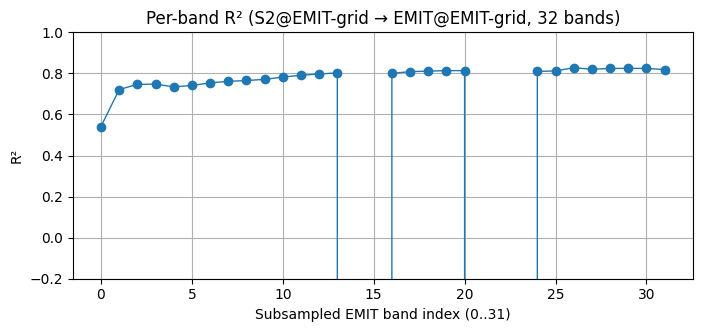

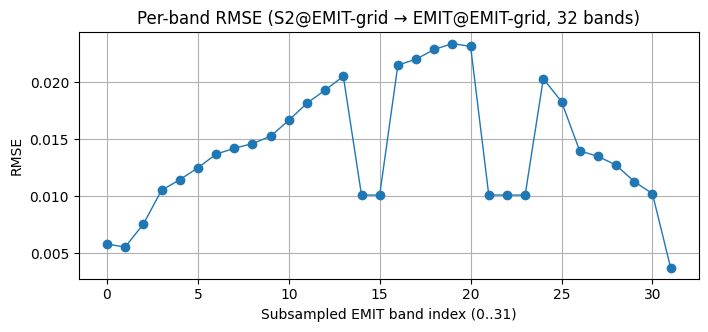

Pred EMIT @10m: (32, 600, 600)


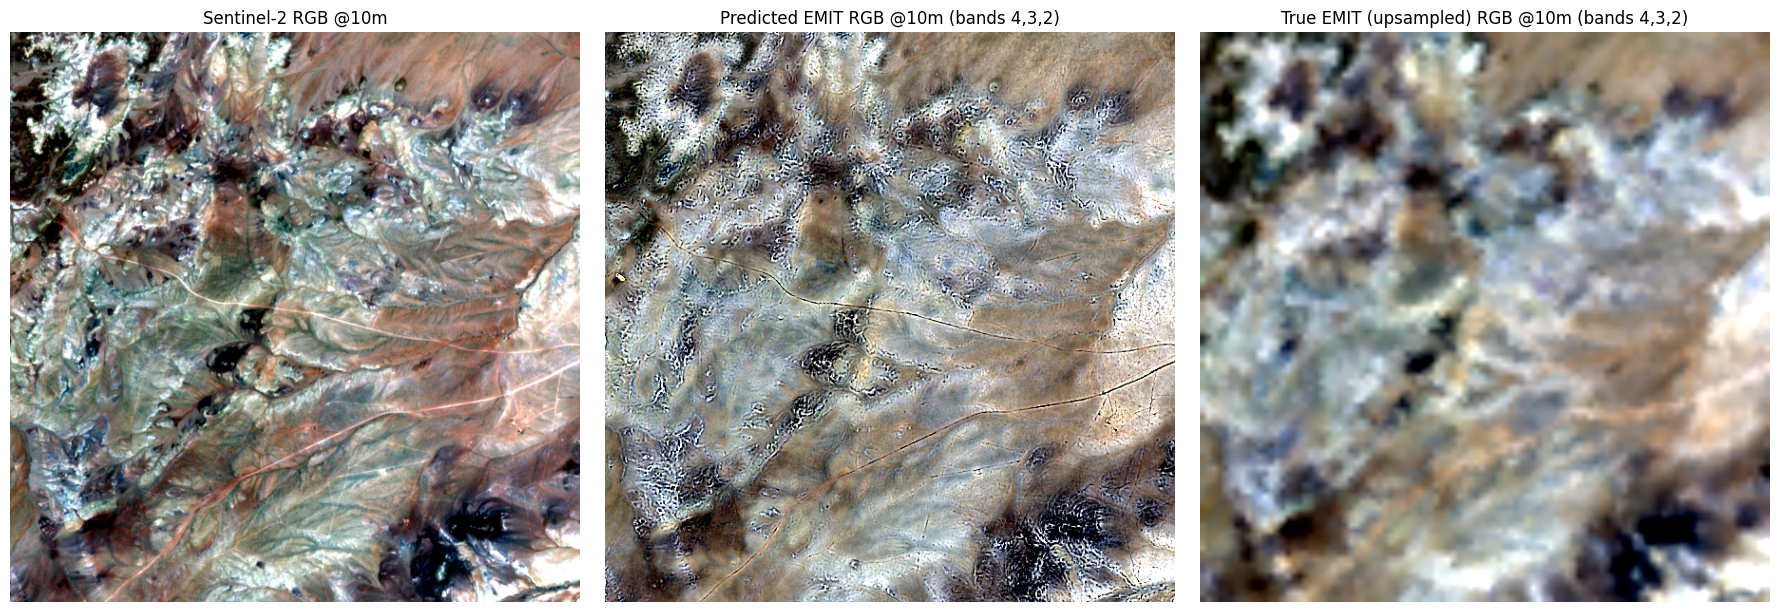

In [24]:
r2_per_band = np.array(r2_per_band)
rmse_per_band = np.array(rmse_per_band)

plt.figure(figsize=(8,3.2))
plt.plot(r2_per_band, marker="o", linewidth=1)
plt.title("Per-band R² (S2@EMIT-grid → EMIT@EMIT-grid, 32 bands)")
plt.xlabel("Subsampled EMIT band index (0..31)")
plt.ylabel("R²")
plt.grid(True)
plt.ylim(-0.2, 1.0)
plt.show()

plt.figure(figsize=(8,3.2))
plt.plot(rmse_per_band, marker="o", linewidth=1)
plt.title("Per-band RMSE (S2@EMIT-grid → EMIT@EMIT-grid, 32 bands)")
plt.xlabel("Subsampled EMIT band index (0..31)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

emit_pred_10m = predict_cube_logit(model, s2_10m, nodata=s2_nodata)
print("Pred EMIT @10m:", emit_pred_10m.shape)

RGB_WAVELENGTHS = {"B": 490, "G": 560, "R": 665}
emitB = int(np.nanargmin(np.abs(wavelengths_32 - RGB_WAVELENGTHS["B"])))
emitG = int(np.nanargmin(np.abs(wavelengths_32 - RGB_WAVELENGTHS["G"])))
emitR = int(np.nanargmin(np.abs(wavelengths_32 - RGB_WAVELENGTHS["R"])))

# print("EMIT RGB indices (32-band cube):", (emitR, emitG, emitB))
# print("EMIT RGB wavelengths (nm):", wavelengths_32[[emitR, emitG, emitB]])


s2_rgb_10m = rgb_from_cube(s2_10m, r=2, g=1, b=0)

emit_true_10m = resample_cube_to_profile(emit_32, emit_prof, s2_prof_10m, resampling=Resampling.bilinear)

emit_pred_rgb_10m = rgb_from_cube(emit_pred_10m, r=emitR, g=emitG, b=emitB)
emit_true_rgb_10m = rgb_from_cube(emit_true_10m, r=emitR, g=emitG, b=emitB)

lo, hi = compute_shared_stretch_params([emit_pred_rgb_10m, emit_true_rgb_10m], p_low=2, p_high=98)
emit_pred_vis = apply_stretch(emit_pred_rgb_10m, lo, hi, gamma=1.1)
emit_true_vis = apply_stretch(emit_true_rgb_10m, lo, hi, gamma=1.1)

s2_lo, s2_hi = compute_shared_stretch_params([s2_rgb_10m], p_low=2, p_high=98)
s2_vis = apply_stretch(s2_rgb_10m, s2_lo, s2_hi, gamma=1.1)

plt.figure(figsize=(18,6))
for i, (img, title) in enumerate([
    (s2_vis, "Sentinel-2 RGB @10m"),
    (emit_pred_vis, f"Predicted EMIT RGB @10m (bands {emitR},{emitG},{emitB})"),
    (emit_true_vis, f"True EMIT (upsampled) RGB @10m (bands {emitR},{emitG},{emitB})"),
], 1):
    ax = plt.subplot(1,3,i)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()
